<a href="https://colab.research.google.com/github/jejjohnson/research_notebook/blob/develop/research_notebook/content/notes/nfs/pyro_nfs_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
#@title Install Packages
!pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb

     |████████████████████████████████| 678 kB 5.5 MB/s 
     |████████████████████████████████| 498 kB 16.4 MB/s 
     |████████████████████████████████| 918 kB 30.4 MB/s 
     |████████████████████████████████| 76 kB 3.2 MB/s 
     |████████████████████████████████| 1.7 MB 35.0 MB/s 
     |████████████████████████████████| 119 kB 48.7 MB/s 
     |████████████████████████████████| 636 kB 44.0 MB/s 
     |████████████████████████████████| 272 kB 37.1 MB/s 
     |████████████████████████████████| 829 kB 46.2 MB/s 
     |████████████████████████████████| 1.3 MB 34.9 MB/s 
     |████████████████████████████████| 97 kB 6.2 MB/s 
     |████████████████████████████████| 133 kB 45.4 MB/s 
     |████████████████████████████████| 170 kB 43.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 142 kB 46.2 MB/s 
     |████████████████████████████████| 294 kB 48.1 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
from torch.utils.data import TensorDataset, DataLoader

# Pyro Settings
import pyro
import pyro.distributions as dist
from pyro import optim, poutine

# GPyTorch Settings
import gpytorch

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

2021-09-01 13:50:18,688:INFO:Using device: cuda


## Data

In [3]:
import pyro.distributions as dist
from pyro.distributions import constraints
from torch.distributions.utils import broadcast_all


class BananaShaped(dist.TorchDistribution):
    arg_constraints = {"a": constraints.positive, "b": constraints.real}
    support = constraints.real_vector

    def __init__(self, a, b, rho=0.9):
        self.a, self.b, self.rho = broadcast_all(a, b, rho)
        self.mvn = dist.MultivariateNormal(
            torch.tensor([0.0, 0.0]),
            covariance_matrix=torch.tensor([[1.0, self.rho], [self.rho, 1.0]]),
        )
        super().__init__(event_shape=(2,))

    def sample(self, sample_shape=()):
        u = self.mvn.sample(sample_shape)
        u0, u1 = u[..., 0], u[..., 1]
        a, b = self.a, self.b
        x = a * u0
        y = (u1 / a) + b * (u0 ** 2 + a ** 2)
        return torch.stack([x, y], -1)

    def log_prob(self, x):
        x, y = x[..., 0], x[..., 1]
        a, b = self.a, self.b
        u0 = x / a
        u1 = (y - b * (u0 ** 2 + a ** 2)) * a
        return self.mvn.log_prob(torch.stack([u0, u1], dim=-1))

class DualMoon(dist.TorchDistribution):
    arg_constraints = {}
    support = constraints.real_vector

    def __init__(self):
        super().__init__(event_shape=(2,))

    def sample(self, sample_shape=()):
        return torch.zeros(sample_shape + self.event_shape)

    def log_prob(self, x):
        term1 = 0.5 * ((torch.linalg.norm(x, dim=-1) - 2) / 0.4) ** 2
        term2 = -0.5 * ((x[..., :1] + torch.Tensor([-2.0, 2.0])) / 0.6) ** 2
        pe = term1 - torch.logsumexp(term2, dim=-1)
        return -pe

## Model

In [4]:
# def model(a, b, rho=0.9):
#     pyro.sample("x", BananaShaped(a, b, rho))
def model():
    pyro.sample("x",  DualMoon())

### Guide

In [5]:
from tqdm.notebook import trange

learning_rate = 0.003
num_steps = 10_000
param_a = 1.15
param_b = 1.1

def fit_guide(guide, args):
    pyro.clear_param_store()
    adam = optim.Adam({"lr": learning_rate})
    svi = SVI(model, guide, adam, Trace_ELBO())
    with trange(num_steps) as pbar:
        for i in pbar:
            loss = svi.step()
            pbar.set_description("[{}]Elbo loss = {:.2f}".format(i, loss))

#### Plot - Raw Data

In [6]:
# 1. Plot samples drawn from BananaShaped distribution
demo_dist = "dualmoon"
if demo_dist == "banana":

    xlim = [-3, 3]
    ylim = [0, 8]
elif demo_dist == "dualmoon":
    xlim = [-3, 3]
    ylim = [-3, 3]
param_a, param_b = 1.15, 1.1
x1, x2 = torch.meshgrid([torch.linspace(*xlim, 100), torch.linspace(*ylim, 100)])
# d = BananaShaped(param_a, param_b)
d = DualMoon()
p = torch.exp(d.log_prob(torch.stack([x1, x2], dim=-1)))

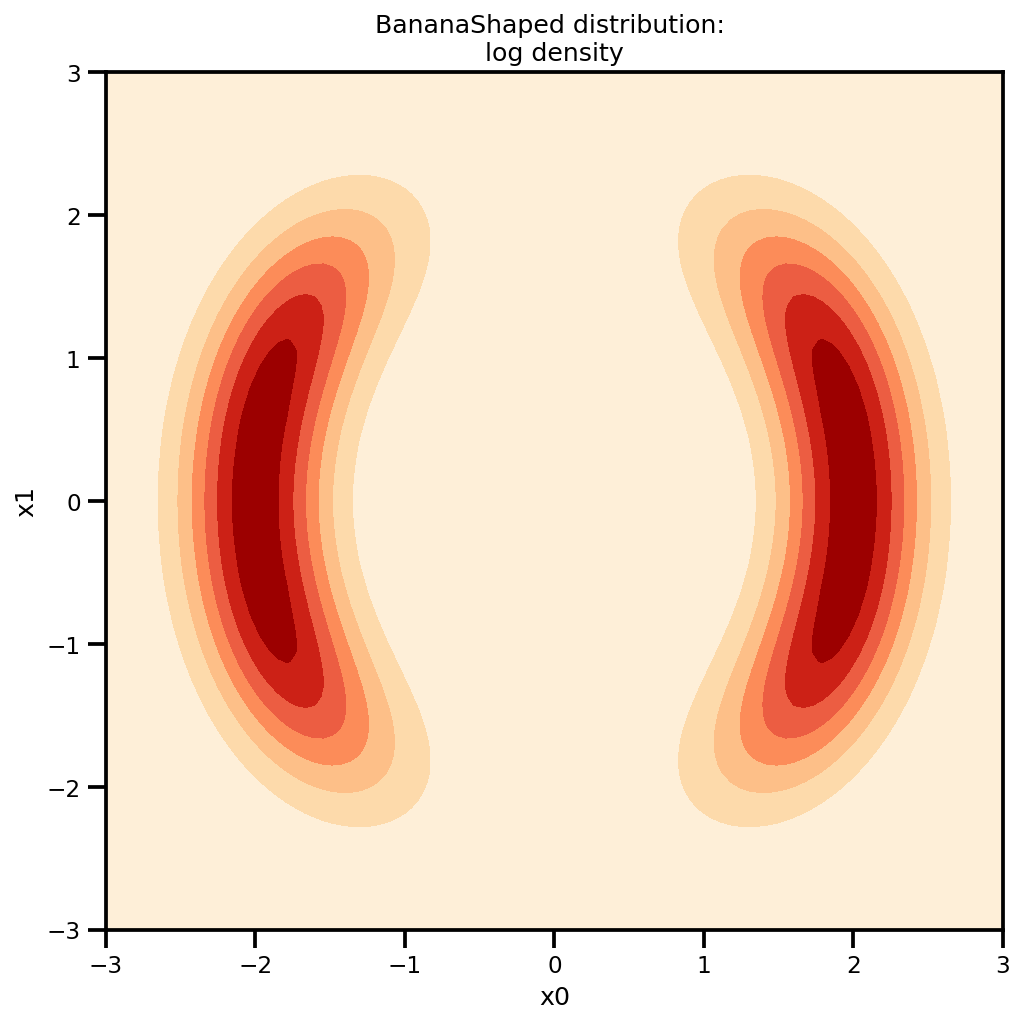

In [7]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)

ax.contourf(
    x1,
    x2,
    p,
    cmap="OrRd",
)
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="BananaShaped distribution: \nlog density",
)
plt.show()


## VI - Diagonal Normal

In [8]:
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormalizingFlow
from pyro.infer import SVI, Trace_ELBO

num_samples = 1_000

guide = AutoDiagonalNormal(model, init_scale=0.05)
fit_guide(guide, None)


  0%|          | 0/10000 [00:00<?, ?it/s]

#### Generate Samples

In [9]:
with pyro.plate("N", num_samples):
    autodiagguide_samples = guide()["x"].detach().cpu().numpy()

#### Plots - Distribution

2021-09-01 13:52:05,471:INFO:NumExpr defaulting to 2 threads.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


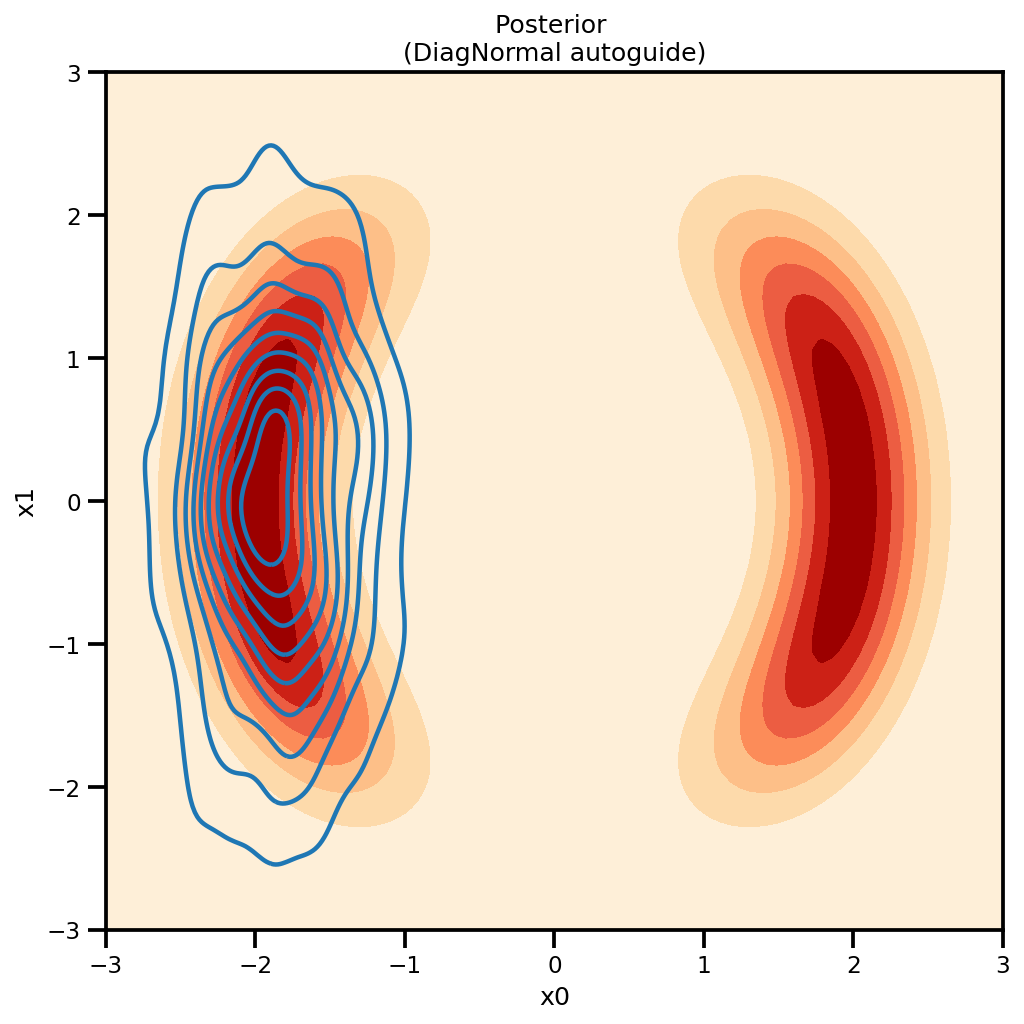

In [10]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(DiagNormal autoguide)",
)

sns.kdeplot(autodiagguide_samples[:, 0], autodiagguide_samples[:, 1], ax=ax)
plt.show()

## VI - Full Normal

In [11]:
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO



guide = AutoNormal(model, init_scale=0.05)
fit_guide(guide, None)

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Generate Samples

In [12]:
num_samples = 1_000

with pyro.plate("N", num_samples):
    autonormal_samples = guide()["x"].detach().cpu().numpy()

#### Plot Guide Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


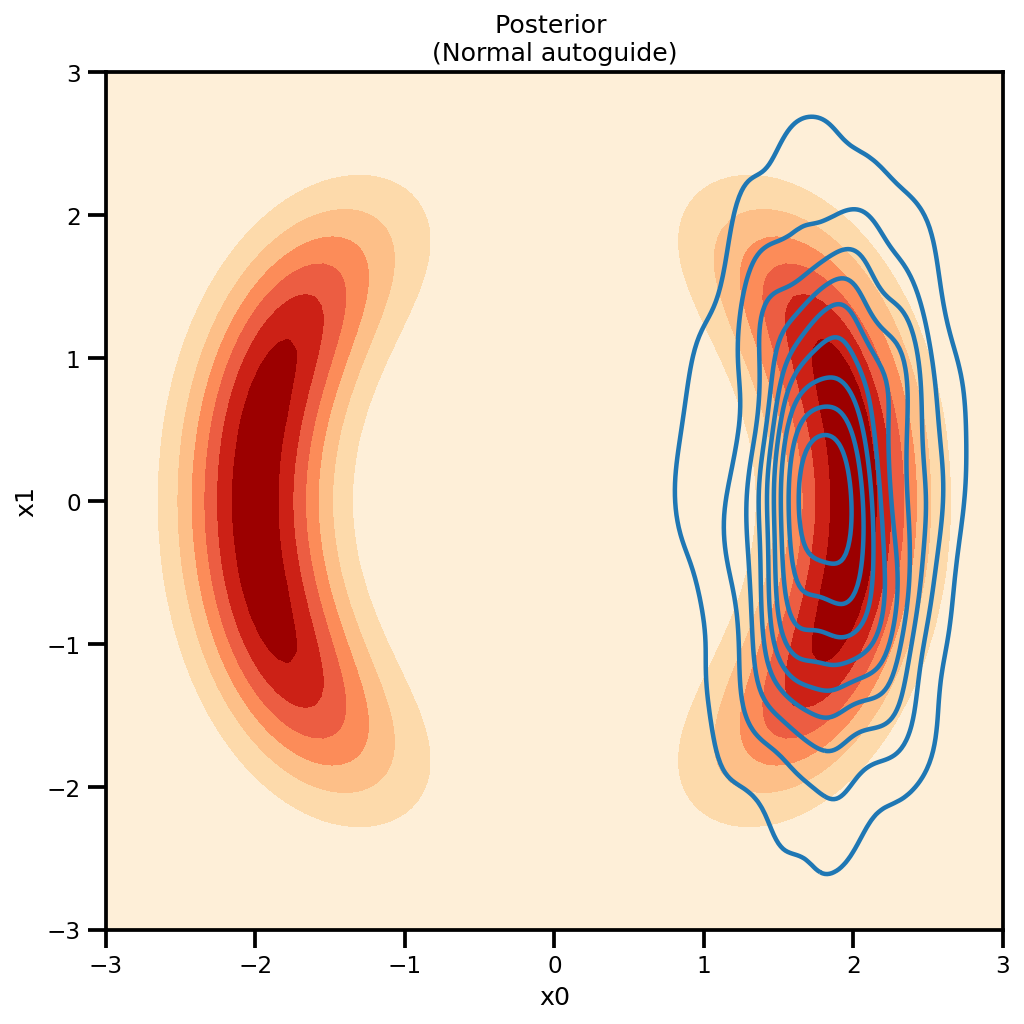

In [13]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(Normal autoguide)",
)

sns.kdeplot(autonormal_samples[:, 0], autonormal_samples[:, 1], ax=ax)
plt.show()

## VI - IAF Flow

In [14]:
from pyro.infer.autoguide import AutoNormalizingFlow, AutoIAFNormal
from pyro.distributions.transforms import affine_autoregressive, iterated
from pyro.infer import SVI, Trace_ELBO


num_flows = 3
# guide = AutoNormalizingFlow(
#     model, partial(iterated, num_flows, affine_autoregressive)
# )
guide = AutoIAFNormal(model,  num_transforms=num_flows)
fit_guide(guide, None)

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Generate Samples

In [15]:
num_samples = 1_000

with pyro.plate("N", num_samples):
    autoiaf_samples = guide()["x"].detach().cpu().numpy()

#### Plots - Guide Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


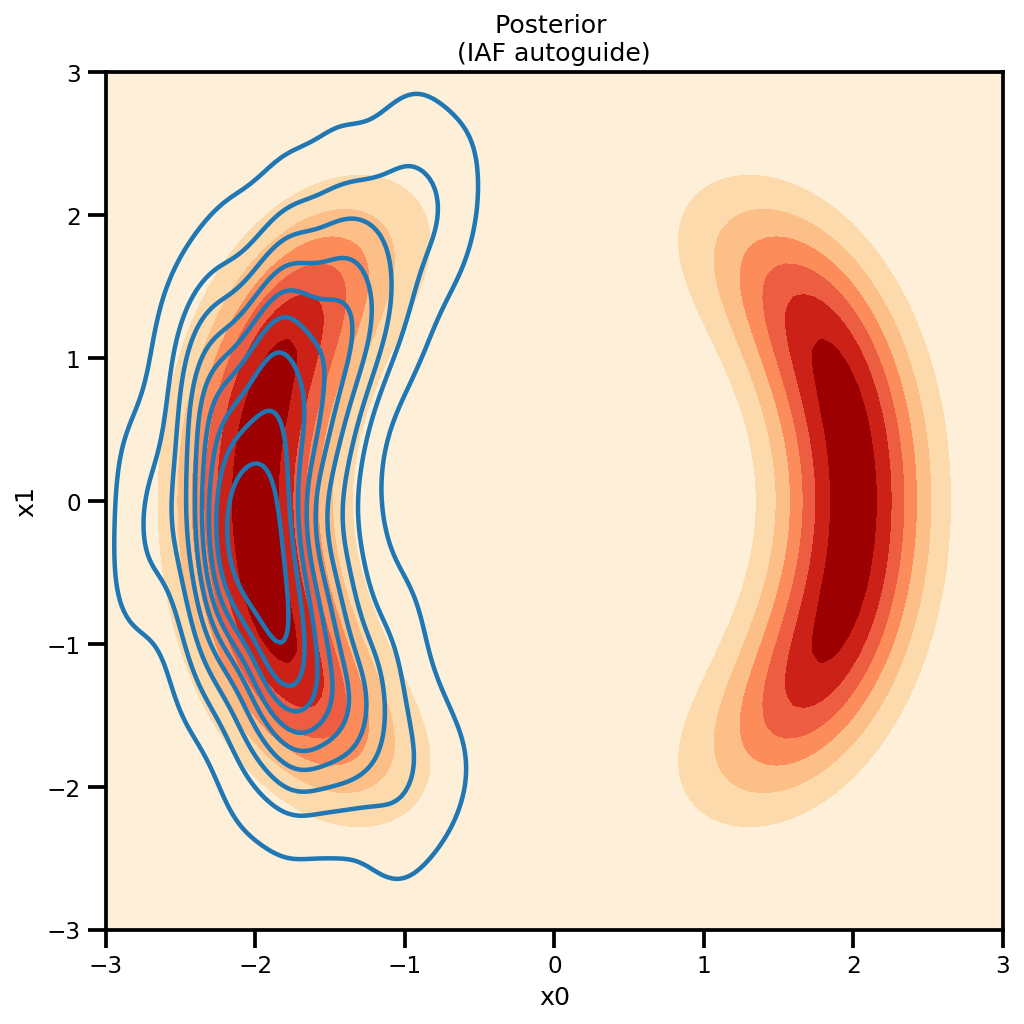

In [16]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(IAF autoguide)",
)

sns.kdeplot(autoiaf_samples[:, 0], autoiaf_samples[:, 1], ax=ax)
plt.show()

## VI - BNAF Flow

In [29]:
from pyro.infer.autoguide import AutoNormalizingFlow
from pyro.distributions.transforms import block_autoregressive, iterated
from functools import partial

input_dim = 2
num_flows = 1
hidden_factors=[8, 8]
def init_bnaf(input_dim):
    return iterated(
        repeats=num_flows, 
        base_fn=block_autoregressive, 
        hidden_factors=hidden_factors, 
        input_dim=input_dim
    )
# bnaf_flow = partial(iterated,  repeats=2)
# bnaf_flow = partial(iterated, block_autoregressive, repeats=2)
guide = AutoNormalizingFlow(
    model, init_bnaf,
)
fit_guide(guide, None)

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Generate Samples

In [30]:
num_samples = 1_000

with pyro.plate("N", num_samples):
    autobnaf_samples = guide()["x"].detach().cpu().numpy()

#### Plots - Guide Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


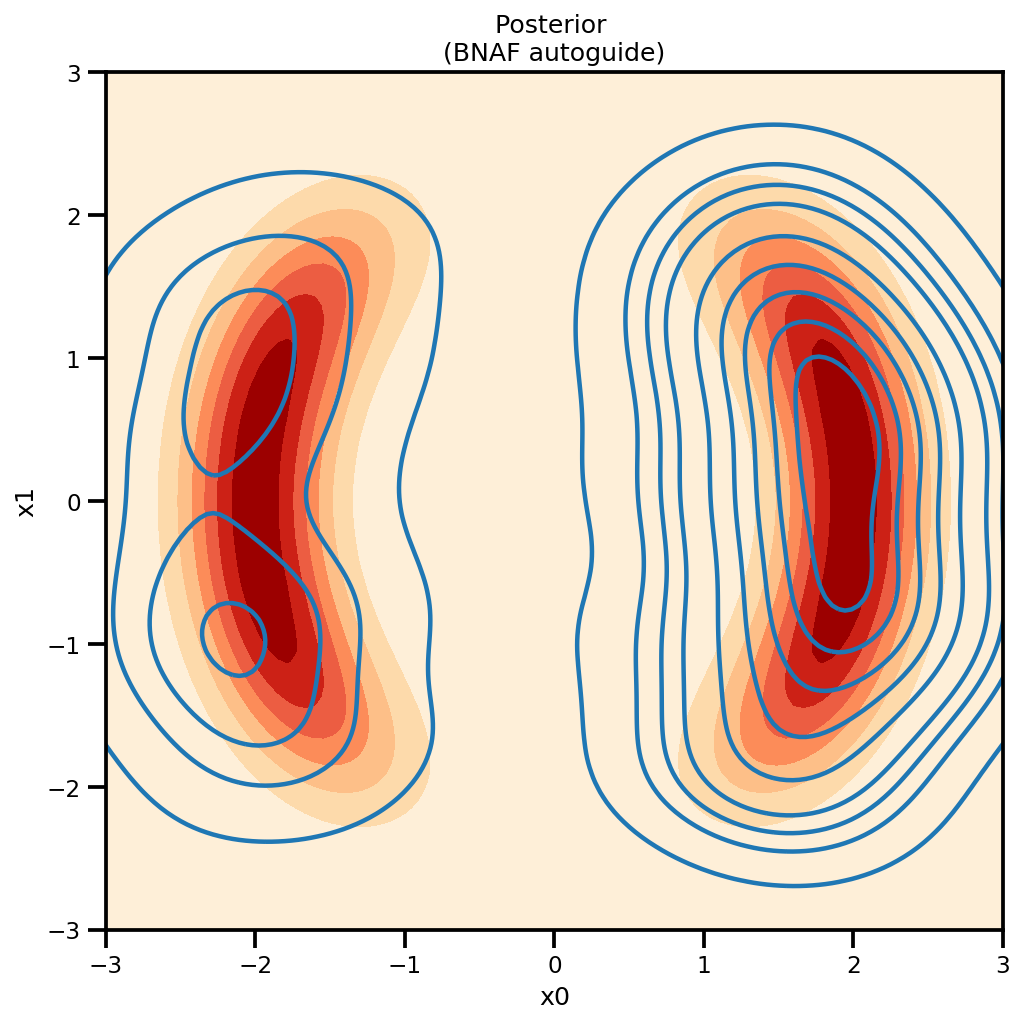

In [31]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(BNAF autoguide)",
)

sns.kdeplot(autobnaf_samples[:, 0], autobnaf_samples[:, 1], ax=ax)
plt.show()

## Neutram - Diag Normal

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormalizingFlow
from pyro.infer import SVI, Trace_ELBO

num_samples = 1_000

guide = AutoDiagonalNormal(model, init_scale=0.05)
fit_guide(guide, None)

In [ ]:
with pyro.plate("N", num_samples):
    autodiagguide_samples = guide()["x"].detach().cpu().numpy()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)


ax.contourf(x1, x2, p, cmap="OrRd")
ax.set(
    xlabel="x0",
    ylabel="x1",
    xlim=xlim,
    ylim=ylim,
    title="Posterior \n(DiagNormal autoguide)",
)

sns.kdeplot(autodiagguide_samples[:, 0], autodiagguide_samples[:, 1], ax=ax)
plt.show()